In [1]:
!pip install uproot awkward numpy matplotlib scikit-learn tqdm -q
import sys
import numpy as np
import awkward as ak
import uproot

print("Python:", sys.version)
print("NumPy:", np.__version__)

Python: 3.10.19 | packaged by conda-forge | (main, Oct 22 2025, 22:29:10) [GCC 14.3.0]
NumPy: 1.26.4


In [2]:
file = uproot.open("work/data/cms.root")
events = file["Events;75"]

events.keys()

['nMuon', 'Muon_pt', 'Muon_eta', 'Muon_phi', 'Muon_mass', 'Muon_charge']

In [3]:
def sample_muons_chunked(file_path, max_muons=1_000_000, chunk_size=1_000_000):
    """
    Stream through CMS events in chunks, collect up to max_muons muons.
    Returns NumPy arrays (pt, eta, phi, charge).
    """
    
    pt_out, eta_out, phi_out, charge_out = [], [], [], []
    collected = 0
    
    with uproot.open(file_path) as file:
        tree = file["Events"]
        branches = ["Muon_pt", "Muon_eta", "Muon_phi", "Muon_charge"]
                    
        for arrays in tree.iterate(branches, step_size=chunk_size, library="ak"):
            pt_flat = ak.flatten(arrays["Muon_pt"])
            eta_flat = ak.flatten(arrays["Muon_eta"])
            phi_flat = ak.flatten(arrays["Muon_phi"])
            charge_flat = ak.flatten(arrays["Muon_charge"])
                    
            to_take = min(len(pt_flat), max_muons - collected)
            if to_take <= 0:
                break
            pt_out.append(pt_flat[:to_take])
            eta_out.append(eta_flat[:to_take])
            phi_out.append(phi_flat[:to_take])
            charge_out.append(charge_flat[:to_take])
                    
            collected += to_take
            if collected >= max_muons:
                break        
                    
    return (
        ak.to_numpy(ak.concatenate(pt_out)),
        ak.to_numpy(ak.concatenate(eta_out)),
        ak.to_numpy(ak.concatenate(phi_out)),
        ak.to_numpy(ak.concatenate(charge_out)).astype(np.int8)
    )
                    
# Usage
    
file_path = "work/data/cms.root"
pt_s, eta_s, phi_s, charge_s = sample_muons_chunked(file_path, max_muons=1_000_000)

print(len(pt_s))
print("pt range:", pt_s.min(), pt_s.max())
print("pt range:", eta_s.min(), eta_s.max())
print("phi range:", phi_s.min(), phi_s.max())
print("charges:", np.unique(charge_s))

1000000
pt range: 3.000001 157191.17
pt range: -6.5745535 7.711927
phi range: -3.14159 3.1415865
charges: [-1  1]


Stats:
                   pt             eta             phi          charge
count  1000000.000000  1000000.000000  1000000.000000  1000000.000000
mean        17.256962        0.015391        0.018131        0.012622
std        192.733276        1.292000        1.816964        0.999921
min          3.000001       -6.574553       -3.141590       -1.000000
25%          6.847683       -1.029470       -1.562295       -1.000000
50%         11.608041        0.010186        0.019706        1.000000
75%         19.028657        1.060996        1.598867        1.000000
max     157191.171875        7.711927        3.141587        1.000000

Correlation Matrix:
              pt       eta       phi    charge
pt      1.000000  0.000295 -0.001097  0.000870
eta     0.000295  1.000000 -0.004929  0.000923
phi    -0.001097 -0.004929  1.000000  0.000489
charge  0.000870  0.000923  0.000489  1.000000


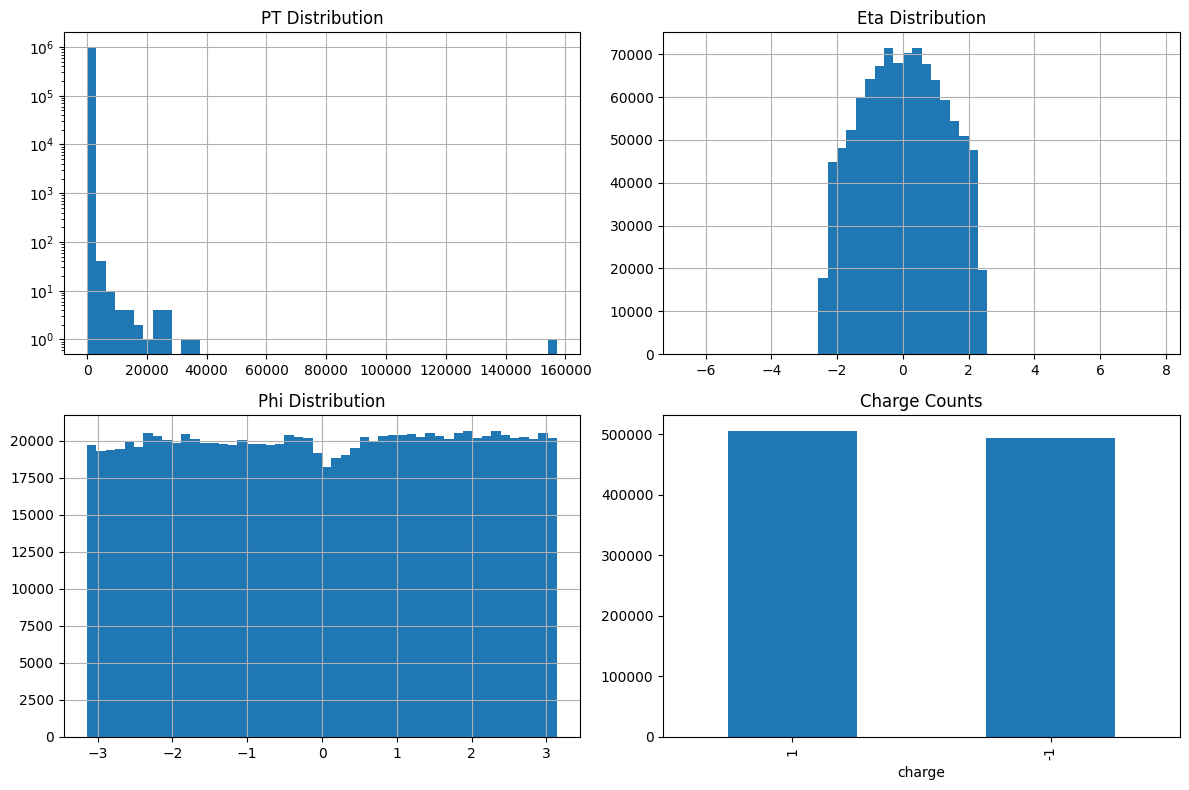

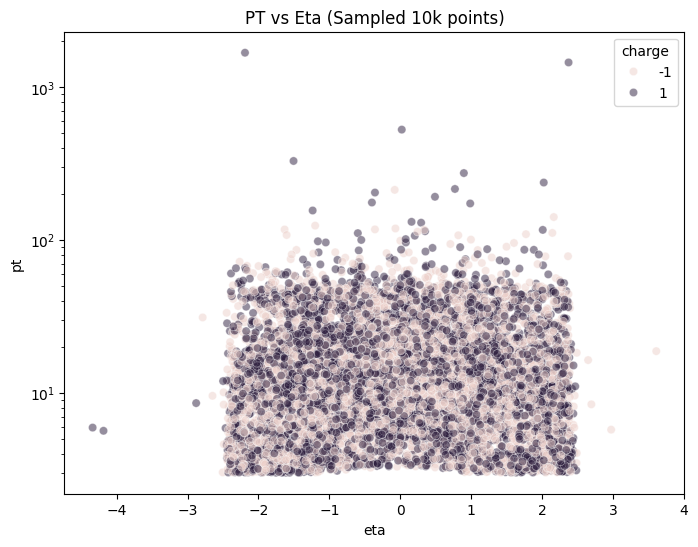

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# DF

df = pd.DataFrame({
    'pt': pt_s,
    'eta': eta_s,
    'phi': phi_s,
    'charge': charge_s
})

# statistics

print("Stats:")
print(df.describe())

#Correlation Matrix

print("\nCorrelation Matrix:")
print(df.corr())

# Charts

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
df['pt'].hist(bins=50, ax=axes[0,0], log=True) #Log because of long tail
axes[0,0].set_title('PT Distribution')
df['eta'].hist(bins=50, ax=axes[0,1])
axes[0,1].set_title('Eta Distribution')
df['phi'].hist(bins=50, ax=axes[1,0])
axes[1,0].set_title('Phi Distribution')
df['charge'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Charge Counts')
plt.tight_layout()
plt.show()

# Scatter Plot:

plt.figure(figsize=(8,6))
sns.scatterplot(x='eta', y='pt', hue='charge', data=df.sample(10000), alpha=0.5)  # Sample for speed
plt.title('PT vs Eta (Sampled 10k points)')
plt.yscale('log')
plt.show()


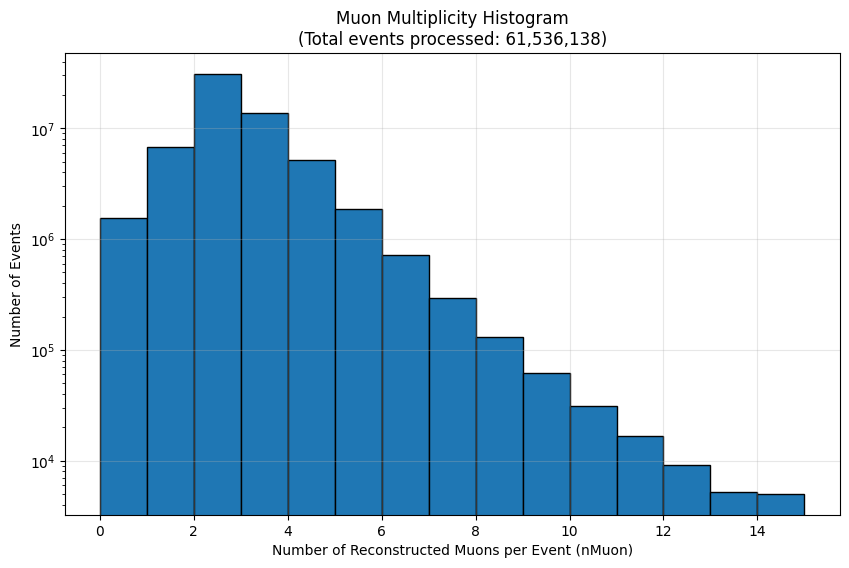

Multiplicity Table (muons per event):
nMuon | Events          | Percentage
------|-----------------|-----------
    0 |       1,550,682 |      2.52%
    1 |       6,718,485 |     10.92%
    2 |      31,104,343 |     50.55%
    3 |      13,823,608 |     22.46%
    4 |       5,193,919 |      8.44%
    5 |       1,882,447 |      3.06%
    6 |         712,735 |      1.16%
    7 |         291,275 |      0.47%
    8 |         129,914 |      0.21%
    9 |          61,748 |      0.10%
   10 |          31,103 |      0.05%
   11 |          16,577 |      0.03%
   12 |           9,071 |      0.01%
   13 |           5,196 |      0.01%
   14 |           5,035 |      0.01%
Total events: 61,536,138


In [10]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt

def get_multiplicity_hist(file_path, chunk_size=1_000_000, max_bins=20):
    """
    Compute and plot muon multiplicity histogram efficiently (chunked).
    Handles Awkward to NumPy conversion safely.
    """
    # Pre-allocate histogram as NumPy int64
    hist = np.zeros(max_bins, dtype=np.int64)
    bins = np.arange(max_bins + 1)  # Bin edges: 0 to max_bins
    
    with uproot.open(file_path) as file:
        tree = file["Events"]
        for arrays in tree.iterate(["nMuon"], step_size=chunk_size, library="ak"):
            n_mu_per_event = arrays["nMuon"]  # Flat Awkward array of counts per event
            
            # Compute histogram per chunk
            chunk_hist_ak, _ = np.histogram(n_mu_per_event, bins=bins)
            
            # Convert to NumPy and add (this fixes the TypeError)
            chunk_hist = ak.to_numpy(chunk_hist_ak)  # Or: np.asarray(chunk_hist_ak)
            hist += chunk_hist
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.bar(np.arange(max_bins), hist, width=1, align='edge', edgecolor='black')
    plt.xlabel("Number of Reconstructed Muons per Event (nMuon)")
    plt.ylabel("Number of Events")
    plt.yscale("log")
    plt.title(f"Muon Multiplicity Histogram\n(Total events processed: {hist.sum():,})")
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Print table
    print("Multiplicity Table (muons per event):")
    print("nMuon | Events          | Percentage")
    print("------|-----------------|-----------")
    total = hist.sum()
    for i in range(max_bins):
        if hist[i] > 0:
            print(f"{i:5d} | {hist[i]:15,} | {100 * hist[i] / total:9.2f}%")
    print(f"Total events: {total:,}")

# Run it
file_path = "work/data/cms.root"
get_multiplicity_hist(file_path, max_bins=15)  # Adjust max_bins if you see high multiplicities

In [13]:
print("pt range:", pt_s.min(), pt_s.max())
print("eta range:", eta_s.min(), eta_s.max())
print("phi range:", phi_s.min(), phi_s.max())
print("charges:", np.unique(charge_s))

pt range: 3.000001 157191.17
eta range: -6.5745535 7.711927
phi range: -3.14159 3.1415865
charges: [-1  1]


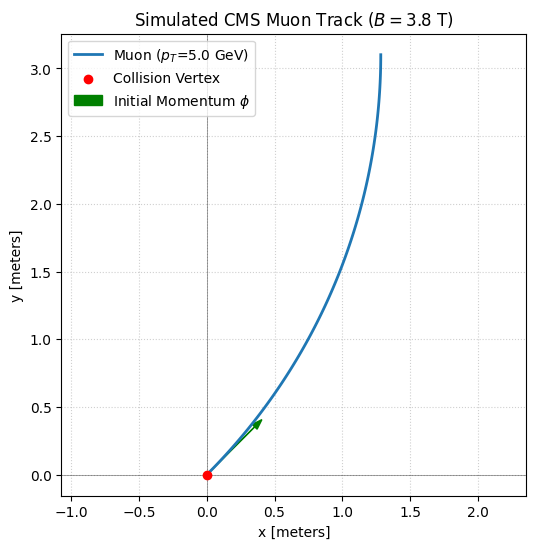

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
B_FIELD = 3.8  # Tesla (CMS Solenoid)

def get_muon_track(pt, phi, charge, n_points=100):
    """
    Calculates the 2D (xy) trajectory of a particle in a uniform magnetic field.
    
    Args:
        pt (float): Transverse momentum in GeV/c
        phi (float): Initial azimuthal angle in radians
        charge (int): Particle charge (+1 or -1)
    
    Returns:
        tuple: (x_points, y_points) arrays
    """
    # 1. Calculate Gyroradius (R in meters, pt in GeV, B in Tesla)
    # Formula: R = pT / (0.3 * B)
    R = pt / (0.3 * B_FIELD)
    
    # 2. Determine the center of curvature
    # The force is F = q(v x B). For B along +z, a positively charged particle
    # moving along +x bends towards -y (Right Hand Rule).
    # We shift the circle center perpendicular to the initial momentum direction.
    
    # Offset distance d = R. 
    # Direction of center is phi - pi/2 * charge (sign dictates bend direction)
    alpha = phi - (np.pi / 2) * charge
    
    x0 = -R * np.cos(alpha)
    y0 = -R * np.sin(alpha)

    # 3. Parameterize the arc
    # We simulate a small arc length. t represents the turning angle.
    # The particle moves along the circle edge.
    # We sweep t from alpha to alpha + (charge * deflection_amount)
    sweep = np.linspace(alpha, alpha + charge * np.pi/4, n_points) # Sweep 45 degrees
    
    x = x0 + R * np.cos(sweep)
    y = y0 + R * np.sin(sweep)
    
    return x, y

# --- Simulation Parameters ---
pt_sim = 5.0      # GeV/chbbi gm  fhjg  h  hj hjjgvv hgvjj uv u
phi_sim = np.pi/4 # 45 degrees
charge_sim = 1    # Positive muon

# Get track data
xr, yr = get_muon_track(pt_sim, phi_sim, charge_sim)

# --- Plotting ---
plt.figure(figsize=(6,6))

# Plot the track
plt.plot(xr, yr, linewidth=2, label=f'Muon ($p_T$={pt_sim} GeV)')

# Plot the collision point
plt.scatter([0], [0], color='red', zorder=5, label='Collision Vertex')

# Plot the initial momentum vector for verification
plt.arrow(0, 0, np.cos(phi_sim)*0.5, np.sin(phi_sim)*0.5, 
          head_width=0.05, color='green', label='Initial Momentum $\phi$')

plt.title(f"Simulated CMS Muon Track ($B={B_FIELD}$ T)")
plt.xlabel("x [meters]")
plt.ylabel("y [meters]")
plt.axhline(0, color='black', linewidth=0.5, alpha=0.5)
plt.axvline(0, color='black', linewidth=0.5, alpha=0.5)
plt.axis('equal')
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

NameError: name 'X' is not defined

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)

y_pred = lin_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mse

5.144030756909501e-10

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

pred = model.predict(X_test)

print("MSE:", mean_squared_error(y_test, pred))

MSE: 1.3336502721229525e-26


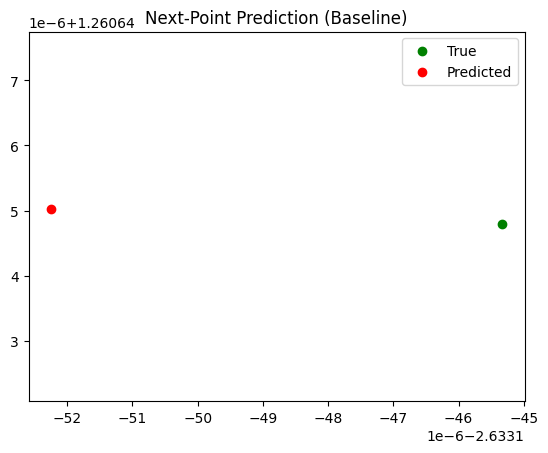

In [27]:
i = 34
true = y_test[i]
pred = y_pred[i]

plt.scatter(true[0], true[1], label="True", color="green")
plt.scatter(pred[0], pred[1], label="Predicted", color="red")
plt.legend()
plt.axis("equal")
plt.title("Next-Point Prediction (Baseline)")
plt.show()